# Постановка задачи

Решить задачу Коши для обыкновенного дифференциального уравнения первого порядка на отрезке $[a, b]$ с шагом $0.05$  явным и неявным методами трапеций, явным методом Рунге-Кутты 4-го порядка и явно-неявным методом Адамса 4-го порядка. 

Оценить погрешность численного решения с использованием правила Рунге (для одношаговых методов) и путем сравнения с точным решением $u(t)$.

В одной системе координат построить график функции $u(t)$ и график одного из полученных численных решений.

### Задача Коши
$$u'= \frac{u^2 + ut}{t^2},\ \ \ t \in [1, 2],\ \ \ u_0=u(1)=0.5$$

### Точное решение
$$u(t)=\frac{t}{2-ln(t)}$$

In [1]:
import math


def f(t, y):
    return (y ** 2 + y * t) / t ** 2


def correct_solution(t):
    return t / (2 - math.log(t))

<hr>

# Краткая теория, реализация методов

### Явный метод трапеций
$(j+1)$-ое приближение функции методом трапеций находится из системы:


\begin{cases}
y_{j+1}=y_j+\frac{\tau}{2} \cdot (f(t_j, y_j) + f(t_{j+1}, y_{j+1}))\\
y_0 = u_0
\end{cases}

Чтобы метод трапеций был <b>явным</b>, $y_{j+1}$ в правой части равенства следует найти явным методом Эйлера. $(j+1)$-ое приближение функции явным методом Эйлера находится из системы:


\begin{cases}
   y_{j+1}=y_j+\tau \cdot f(t_j, y_j)\\
   y_0 = u_0
\end{cases}




In [2]:
def explicit_euler_method(t_j, y_j, tau, right_border):
    """Реализация явного метода Эйлера"""
    while t_j <= right_border:
        y_j += tau * f(t_j, y_j)
        t_j += tau
        yield t_j, y_j


def explicit_trapezium_method(t_j, y_j, tau, right_border):
    """Реализация явного метода трапеций"""
    for t_j, y_euler in explicit_euler_method(t_j, y_j, tau, right_border):
        y_j += tau * (f(t_j, y_j) + f(t_j + tau, y_euler)) / 2
        yield y_j


### Неявный метод трапеций

Чтобы метод трапеций был <b>неявным</b>, $y_{j+1}$ в правой части равенства можно найти, решив нелинейное уравнение с помощью метода Ньютона. Он заключается в следующем:
$$g(x) = 0$$

$$x^{(n + 1)}=x^{(n)} - \frac{g(x^{(n)})}{g'(x^{(n)})},\ где\ n - номер\ итерации$$

В нашем случае получаем:
$$g(y_{j+1}) = y_{j + 1} - y_{j} - \frac{\tau}{2} \cdot \big(f(t_{j}, y_{j}) + f(t_{j + 1}, y_{j + 1})\big) = 0$$

$$g'(y_{j + 1}) = 1 - \frac{\tau}{2} \cdot \Bigg(\frac{2y}{t^2} + \frac{1}{t}\Bigg)$$

$$y^{(n + 1)}_{j+1} = y^{(n)}_{j+1} - \frac{g(y^{(n)}_{j+1})}{g'(y^{(n)}_{j+1})}$$

Возьмём $\varepsilon = 10^{-3}$. Итерационный процесс будем продолжать до тех пор, пока 

$$|y^{(n + 1)}_{j + 1} - y^{(n)}_{j + 1}| \ge \varepsilon$$

In [3]:
def g(t_j, y_j, y_n, tau):
    return y_n - y_j - (tau * (f(t_j, y_j) + f(t_j + tau, y_n))) / 2


def derivative(t, y, tau):
    """g'(y)"""
    return 1 - (tau * ((2 * y / t ** 2) + 1 / t)) / 2


def newton_method(t_j, y_j, tau):
    """Реализация метода Ньютона"""
    eps = 10e-3
    y = y_j
    while True:
        y_prev = y
        y -= (g(t_j, y_j, y, tau) / derivative(t_j, y, tau))
        if abs(y - y_prev) < eps:
            return y


def implicit_trapezium_method(t_j, y_j, tau, right_border):
    """Реализация неявного метода трапеций"""
    while t_j <= right_border:
        y_newton = newton_method(t_j, y_j, tau)
        y_j += tau * (f(t_j, y_j) + f(t_j + tau, y_newton)) / 2
        t_j += tau
        yield y_j


### Метод Рунге-Кутты 4 порядка

$(j+1)$-е приближение функции явным методом Рунге-Кутты 4 порядка находится из системы:

\begin{cases}
y_{j + 1} = y_j + \frac{\tau}{6} \cdot (k_1 + 2k_2 +2k_3 + k_4)\\
k_1 = f(t_j, y_j)\\
k_2 = f(t_j + \frac{\tau}{2}, y_j + \frac{\tau \cdot k_1}{2})\\
k_3 = f(t_j + \frac{\tau}{2}, y_j + \frac{\tau \cdot k_2}{2})\\
k_4 = f(t_j + \tau, y_j + \tau \cdot k_3)
\end{cases}

In [4]:
def k2(t, y, tau):
    return f(t + tau / 2, y + tau * f(t, y) / 2)


def k3(t, y, tau):
    return f(t + tau / 2, y + tau * k2(t, y, tau) / 2)


def k4(t, y, tau):
    return f(t + tau, y + tau * k3(t, y, tau))


def explicit_runge_kutta_method(t_j, y_j, tau, right_border):
    while t_j <= right_border:
        y_j += tau * (f(t_j, y_j) +
                      2 * k2(t_j, y_j, tau) +
                      2 * k3(t_j, y_j, tau) +
                      k4(t_j, y_j, tau)) / 6
        t_j += tau
        yield y_j

### Явно-неявный метод Адамса 4 порядка

Формула для интерполяционного метода Адамса 4-го порядка выглядит следующим образом:

$$y_{j+1} = y_j + \frac{\tau}{24} \cdot \big(9f_{j+1} + 19f_j - 5f_{j-1} + f_{j-2} \big),$$

$$где\ f_{j+1} = f(t_{j+1}, y_{j+1}),\ ...$$

Чтобы найти $f_{j+1}$, воспользуемся экстраполяционным методом Адамса 4-го порядка. Его рекуррентная формула выглядит так:

$$y_{j+1} = y_j + \frac{\tau}{24} \cdot \big(55f_{j} - 59f_{j-1} + 37f_{j-2} - 9f_{j-3} \big)$$

Чтобы начать считать, $y_1, y_2\ и\ y_3$ получим методом Рунге-Кутты.

In [5]:
def explicit_adams_method(t_j, y_j, y1, y2, y3, tau, right_border):
    """y3 is y[j - 3], y2 is y[j - 2] etc."""
    while t_j <= right_border:
        y_j_prev = y_j
        y_j += tau * (55 * f(t_j, y_j) -
                      59 * f(t_j - tau, y1) +
                      37 * f(t_j - 2 * tau, y2) -
                      9 * f(t_j - 3 * tau, y3)) / 24
        t_j += tau
        y3 = y2
        y2 = y1
        y1 = y_j_prev
        yield y_j


def implicit_adams_method(t_j, y_j, tau, right_border):
    i = 1
    y3 = y_j
    y2, y1, y_j = explicit_runge_kutta_method(t_j, y_j, tau, t_j + 3 * tau)
    for y_adams in explicit_adams_method(
            t_j + 3 * tau, y_j, y1, y2, y3, tau, right_border):
        y_j_prev = y_j
        y_j += tau * (9 * f(t_j + 3 * tau, y_adams) +
                      19 * f(t_j + 2 * tau, y_j) -
                      5 * f(t_j + tau, y1) +
                      9 * f(t_j, y2)) / 24

        yield y_j
        t_j += tau
        y2 = y1
        y1 = y_j_prev
        i += 1

### Функции для оценки точности методов

In [6]:
import numpy as np


t = np.arange(1.05, 2.05, 0.05)
correct = np.array([correct_solution(t) for t in np.arange(1.05, 2.05, 0.05)])

trap_exp = np.array(list(explicit_trapezium_method(1, 0.5, 0.05, 2)))
trap_imp = np.array(list(implicit_trapezium_method(1, 0.5, 0.05, 2)))

runge = np.array(list(explicit_runge_kutta_method(1, 0.5, 0.05, 2)))
adams = np.array(list(implicit_adams_method(1, 0.5, 0.05, 2)))


half_trap_exp = np.array(list(explicit_trapezium_method(1, 0.5, 0.1, 2)))
half_trap_imp = np.array(list(implicit_trapezium_method(1, 0.5, 0.1, 2)))
half_runge = np.array(list(explicit_runge_kutta_method(1, 0.5, 0.1, 2)))


def abs_approximation_error(correct_sol, values):
    """Функция оценки точности (максимум модуля погрешности)"""
    return max(abs(correct_sol - values))


def runge_approximation_error(values, half_values, precision=1):
    """Функция оценки точности по правилу Рунге"""
    return max(abs(half_values - values[1::2])) / (2^precision - 1)


### График явного метода трапеций рядом с точным решением

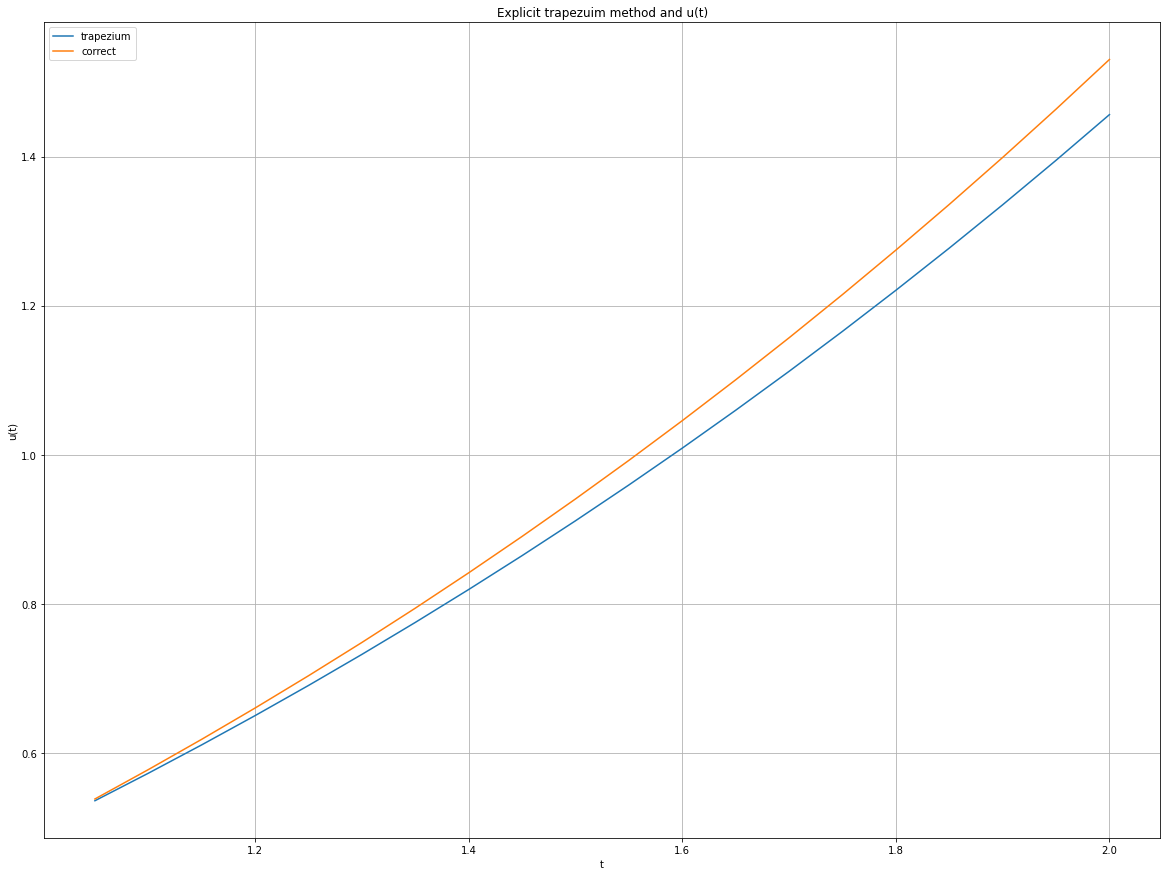

In [7]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(t, trap_exp, label='trapezium')
ax.plot(t, correct, label='correct')

ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.set_title('Explicit trapezuim method and u(t)')
ax.grid()
ax.legend()
plt.show()

<hr>

# Сравнительная таблица методов


| j | $t_j$ | $u(t_j)$ | explicit trapezium | implicit trapezium | Runge-Kutta 4 | implicit Adams |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 1.05 | 0.53812767 | 0.53575874 | 0.53812908 | 0.53812765
| 2 | 1.10 | 0.57752186 | 0.57266770 | 0.57752496 | 0.57752183
| 3 | 1.15 | 0.61820045 | 0.61074205 | 0.61820552 | 0.61820040
| 4 | 1.20 | 0.66018278 | 0.64999811 | 0.66019012 | 0.66018271 | 0.67653038
| 5 | 1.25 | 0.70348958 | 0.69045333 | 0.70349950 | 0.70348950 | 0.73779281
| 6 | 1.30 | 0.74814299 | 0.73212623 | 0.74815581 | 0.74814290 | 0.80175806
| 7 | 1.35 | 0.79416651 | 0.77503645 | 0.79418257 | 0.79416640 | 0.86906081
| 8 | 1.40 | 0.84158499 | 0.81920470 | 0.84160465 | 0.84158486 | 0.93983688
| 9 | 1.45 | 0.89042468 | 0.86465276 | 0.89044832 | 0.89042453 | 1.01420964
| 10 | 1.50 | 0.94071319 | 0.91140355 | 0.94074120 | 0.94071302 | 1.09232866
| 11 | 1.55 | 0.99247952 | 0.95948104 | 0.99251232 | 0.99247934 | 1.17435396
| 12 | 1.60 | 1.04575411 | 1.00891037 | 1.04579214 | 1.04575391 | 1.26045563
| 13 | 1.65 | 1.10056884 | 1.05971777 | 1.10061256 | 1.10056861 | 1.35081518
| 14 | 1.70 | 1.15695705 | 1.11193067 | 1.15700695 | 1.15695680 | 1.44562641
| 15 | 1.75 | 1.21495361 | 1.16557765 | 1.21501020 | 1.21495334 | 1.54509626
| 16 | 1.80 | 1.27459496 | 1.22068855 | 1.27465879 | 1.27459466 | 1.64944589
| 17 | 1.85 | 1.33591913 | 1.27729440 | 1.33599078 | 1.33591881 | 1.75891182
| 18 | 1.90 | 1.39896583 | 1.33542757 | 1.39904589 | 1.39896547 | 1.87374711
| 19 | 1.95 | 1.46377646 | 1.39512171 | 1.46386558 | 1.46377607 | 1.99422283
| 20 | 2.00 | 1.53039422 | 1.45641186 | 1.53049308 | 1.53039381 | 2.12062952
| --- | --- | --- | --- | --- | --- | --- |
|  |  | 0 | 7.4e-2 | 9.9e-5 | 4.1e-7 | 5.9e-1
|  |  |  | 3.1e-2 | 9.5e-5 | 5.8e-6 |

<b>Примечание:</b> в предпоследней строке вычислено значение $max |u(t_j) - y_j|$ для каждого из методов, а в последней — $max\frac{|y_j^{\tau/2}-y_j^{\tau}|}{2^p - 1}$.

# Выводы

По сравнению с явным методом трапеций, неявный метод продемонстрировал более высокую точность приближения (что, в целом, было ожидаемо, с учётом разных степеней точности методов). Явный метод Рунге-Кутты 4 порядка, ожидаемо, позволил получить ещё более близкое к точному решению приближение. Интерполяционный метод Адамса, несмотря на многошаговость и сложность реализации, показал гораздо худший результат, чем любой из одношаговых методов.